In [1]:
import pandas as pd
import numpy as np

In [2]:
file_name= 'Downloads/SOP/india/IAHR74FL.DAT'

In [6]:
cluster_file = 'Downloads/SOP/india/indiaCSV.csv'
cluster_all = []
wealth_all = []
with open(file_name) as f:
    for line in f:
        cluster = int(line[15:23])
        wealth = int(line[236:244]) / 100000.0
        cluster_all.append(cluster)
        wealth_all.append(wealth)

df = pd.DataFrame({'cluster': cluster_all, 'wlthindf': wealth_all})
cluster_avg_asset = df.groupby('cluster')['wlthindf'].median().reset_index()

df_location = pd.read_csv(cluster_file)[['DHSCLUST', 'LATNUM', 'LONGNUM']]
result = cluster_avg_asset.merge(df_location, how='inner', left_on='cluster', right_on='DHSCLUST')[['cluster', 'wlthindf', 'LATNUM', 'LONGNUM']]
result.rename(columns={'LATNUM': 'latitude', 'LONGNUM':'longitude'}, inplace=True)
result.to_csv('Downloads/SOP/india/india_avg_asset', index=False)

In [12]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np

In [13]:
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)


# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [14]:
raster_file = 'Downloads/SOP/F2018/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('Downloads/SOP/india/nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [39]:
# get nightlight features for each cluster
def get_nightlight_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'id': idx, 'max_': max_, 'min_': min_, 'mean_': mean_, 
                      'median_': median_, 'std_': std_, 'wealth': wealth})


clusters = pd.read_csv('Downloads/SOP/india/india_avg_asset.csv')
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv('Downloads/SOP/india/DHS_nightlights.csv', index=None)

(0, 50)

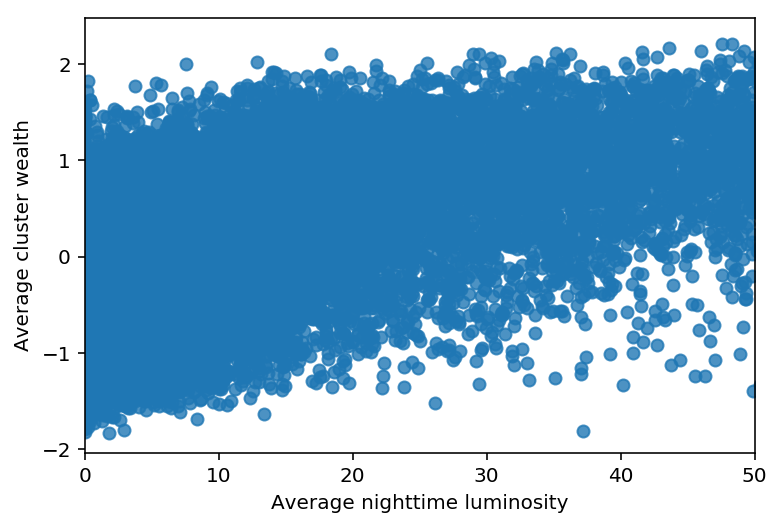

In [40]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, 50])

(0, 25)

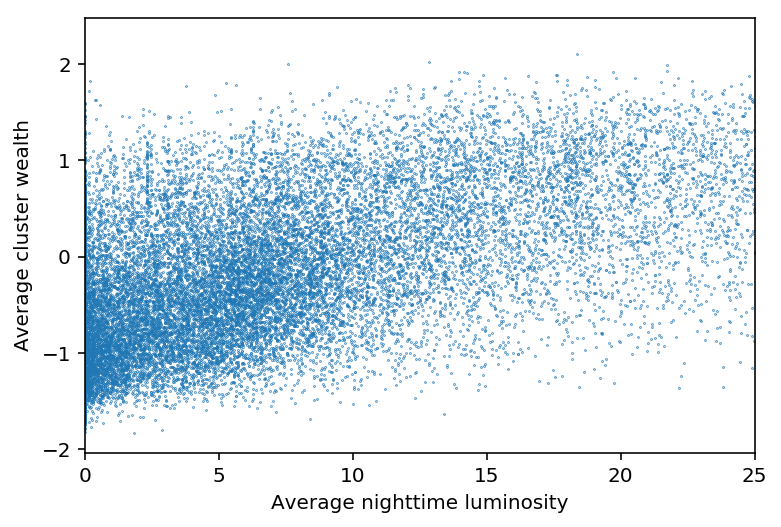

In [52]:
plt.plot( 'mean_', 'wealth', data=data_all, linestyle='', marker='o',markersize=0.3)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, 25])

In [30]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = pd.read_csv('Downloads/SOP/india/DHS_nightlights.csv')
data_all = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].as_matrix()
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print ('R^2 of the best model: {:.3f}'.format(np.max(final)))

C:\Users\pranay\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


R^2 of the best model: 0.436


In [46]:
from sklearn.linear_model import LinearRegression